# Assess the performance metrics of a batch of SRlite

In [1]:
import plotnine
from plotnine import *
import pandas as pd
import glob

import os, sys
sys.path.append('/home/pmontesa/code/geoscitools')
import footprintlib

import numpy as np

/home/pmontesa/.local/lib/python3.8/site-packages/plotnine/geoms/geom_map.py:8: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).


# SRlite metrics analysis (example)  
- use this to filter validation & to inform training chip selection so you dont train with chips from bad data  
- develop this for Alaska in `code/geoscitools/above_shrubs_model_plan.ipynb`

#### Note: below SR data is a Senegal example, b/c metrics CSVs exist - switch to Alaska once CSVs are ready

In [2]:
import importlib
importlib.reload(footprintlib)

<module 'footprintlib' from '/home/pmontesa/code/geoscitools/footprintlib.py'>

In [4]:
region_df_list = []
SRLITE_REG_CHOICE = 'RMA'
for REGION in ['CAS','ETZ','SRV']:
    OUTDIR_TMP = f'/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/senegal/{REGION}/csv'
    srlite_metrics_df = pd.concat([footprintlib.get_attributes_from_filename(pd.read_csv(csv_fn), f'SR ({REGION})', f'_{SRLITE_REG_CHOICE}_SRLite_statistics', filename=os.path.basename(csv_fn), DROP_FILE_DUPLICATES=False) for csv_fn in glob.glob(OUTDIR_TMP + '/*.csv')])
    region_df_list.append(srlite_metrics_df)

srlite_metrics_df = pd.concat(region_df_list)

## SRlite metrics csvs for Alaska batches

In [4]:
region_df_list = []
SRLITE_REG_CHOICE = 'RMA'
for BATCH in ['batch_1']:
    OUTDIR_TMP = f'/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/{BATCH}/8_band_csv/**/csv'
    srlite_metrics_df = pd.concat([footprintlib.get_attributes_from_filename(pd.read_csv(csv_fn), f'SR ({BATCH})', f'_{SRLITE_REG_CHOICE}_SRLite_statistics', filename=os.path.basename(csv_fn), DROP_FILE_DUPLICATES=False) for csv_fn in glob.glob(OUTDIR_TMP + '/*.csv')])
    region_df_list.append(srlite_metrics_df)

srlite_metrics_df = pd.concat(region_df_list)

In [152]:
srlite_metrics_df.columns

Index(['Unnamed: 0', 'index', 'band_name', 'model', 'intercept', 'slope',
       'r2_score', 'explained_variance', 'mbe', 'mae', 'mape', 'medae', 'mse',
       'rmse', 'mean_ccdc_sr', 'mean_evhr_srlite', 'mae_norm', 'rmse_norm',
       'file', 'type', 'footprint_name', 'catid', 'sensor', 'year', 'month',
       'date'],
      dtype='object')

#### Get count of SRlite catids

In [5]:
count_catid_bands = srlite_metrics_df.groupby('catid').aggregate({'band_name':'count'}).reset_index()
print(count_catid_bands.shape)
count_catid_bands.head()

(1916, 2)


,catid,band_name
0,1030010005333400,8
1,103001000617C000,8
2,10300100061B1900,8
3,1030010006422800,8
4,10300100064B1E00,8


### Get vhr metadata from associated TOAs

### Find catid for which all bands have r2_score > threshold

In [10]:
THRESH_R2_SCORE = 0.25

In [11]:
smry_catid_r2_score = srlite_metrics_df.groupby(['catid','band_name']).aggregate({'r2_score':'first'}).reset_index().groupby(['catid']).aggregate({'r2_score':'min'}).rename(columns={'r2_score':'r2_score_band_min'}).reset_index()
print(smry_catid_r2_score.shape)
smry_catid_r2_score.head()

(1916, 2)


,catid,r2_score_band_min
0,1030010005333400,-0.970634
1,103001000617C000,0.498273
2,10300100061B1900,0.820897
3,1030010006422800,-0.591006
4,10300100064B1E00,-0.455179


In [12]:
proportion_gt_thresh_r2_score = np.round(len(smry_catid_r2_score[smry_catid_r2_score.r2_score_band_min > THRESH_R2_SCORE])/ len(smry_catid_r2_score), 3) * 100
proportion_gt_thresh_r2_score = proportion_gt_thresh_r2_score.astype(str) + '%'
proportion_gt_thresh_r2_score

'36.8%'

## Get final set of SRlite to use for training and model application

In [13]:
def classifier(row):
    if row["r2_score_band_min"] >= THRESH_R2_SCORE:
        return "include"
    else:
        return "exclude"

smry_catid_r2_score["srlite_use_class"] = smry_catid_r2_score.apply(classifier, axis=1)

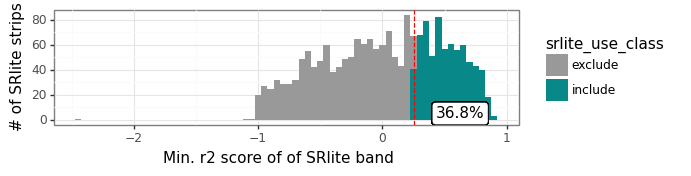

<ggplot: (1455527817933)>

In [14]:
(
    ggplot(smry_catid_r2_score.dropna())
    + geom_histogram(aes(x='r2_score_band_min', fill='srlite_use_class'), binwidth=0.05)
    + scale_fill_manual(values=['#999999','#088888'], name='')
    + geom_vline(xintercept=THRESH_R2_SCORE, color='red', linetype='dashed')
    + theme_bw()
    + theme(figure_size=(6,1.5))
    + labs(y='# of SRlite strips', x='Min. r2 score of of SRlite band')
    + geom_label(aes(x= THRESH_R2_SCORE + ( 0.5 * (1-THRESH_R2_SCORE)), y=5), label= (proportion_gt_thresh_r2_score))
    
)

### Make list of catids to include in modeling (train, apply)

In [16]:
# Get list of catids of class 'include'
list_catids_include = smry_catid_r2_score[smry_catid_r2_score.srlite_use_class == 'include'].catid.to_list()
len(list_catids_include)

705

## Plots show metrics separated by threshold of r2 score

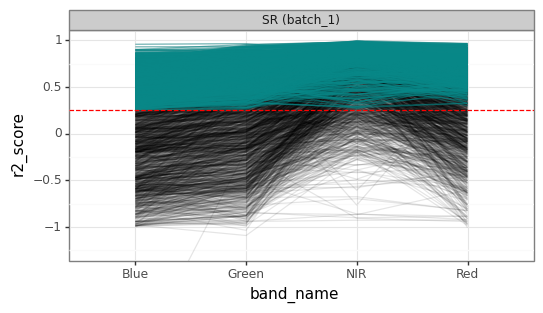

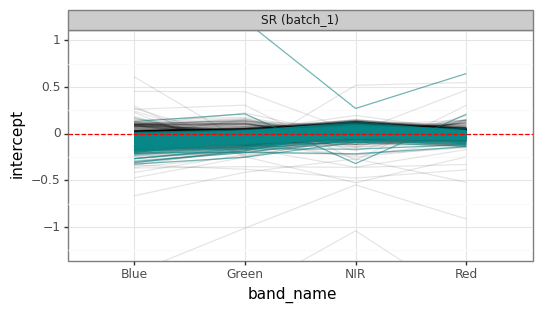

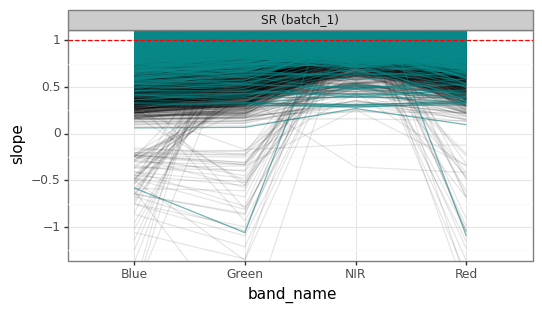

In [18]:
SUBSET_DF = srlite_metrics_df[srlite_metrics_df.catid.isin(list_catids_include)].dropna()
HLINE = [THRESH_R2_SCORE, 0, 1]

for i, Y_VAR in enumerate(['r2_score', 'intercept', 'slope']):
    print(
        ggplot(srlite_metrics_df.dropna())
            + geom_line(aes(x='band_name', y=Y_VAR, group='catid'), alpha=0.1)
        + geom_line(data = SUBSET_DF, mapping = aes(x='band_name', y=Y_VAR, group='catid'), alpha=0.5, color='#088888')
            + geom_hline(yintercept = HLINE[i], linetype='dashed', color='red')
            #+ geom_vline(xintercept=1, linetype='dashed', color='red')
            + facet_wrap('~type')
            + theme_bw()
            + coord_cartesian(ylim=(-1.25,1))
            #+ labs(title='SR-lite model parameters')
        + theme(figure_size=(6,3))
    )

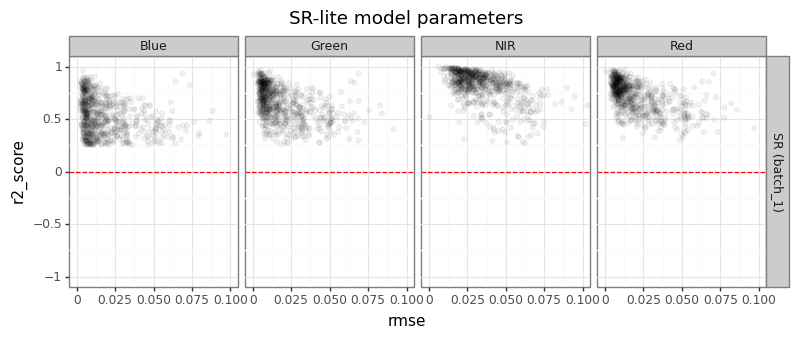

<ggplot: (1455167075801)>

In [19]:
(
    ggplot(SUBSET_DF.dropna())
        + geom_point(aes(x='rmse', y='r2_score'), alpha=0.05)
        + geom_hline(yintercept=0, linetype='dashed', color='red')
        + geom_vline(xintercept=1, linetype='dashed', color='red')
        + facet_grid('type~band_name')
        + theme_bw()
    + coord_cartesian(xlim=(0,0.1), ylim=(-1,1))
        + labs(title='SR-lite model parameters')
        + theme(figure_size=(9, 3), strip_text = element_text(size=9))
)

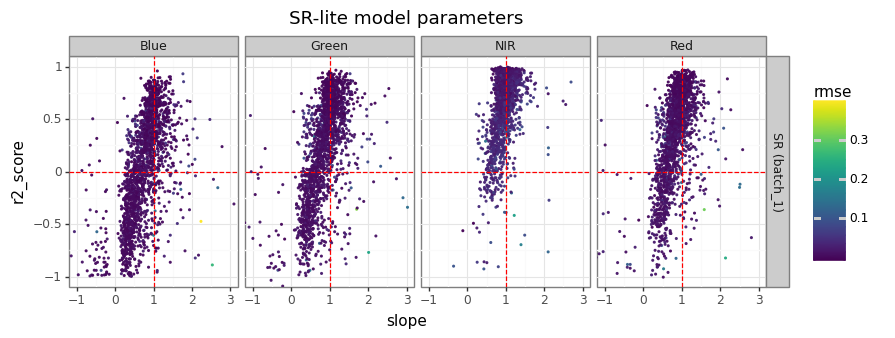

<ggplot: (1455525524378)>

In [20]:
(
    ggplot(srlite_metrics_df.dropna())
        + geom_point(aes(x='slope', y='r2_score', color='rmse'), size=0.25, alpha=0.91)
        + geom_hline(yintercept=0, linetype='dashed', color='red')
        + geom_vline(xintercept=1, linetype='dashed', color='red')
        + facet_grid('type~band_name')
        + theme_bw()
    + coord_cartesian(xlim=(-1,3), ylim=(-1,1))
        + labs(title='SR-lite model parameters')
        + theme(figure_size=(9, 3), strip_text = element_text(size=9))
)

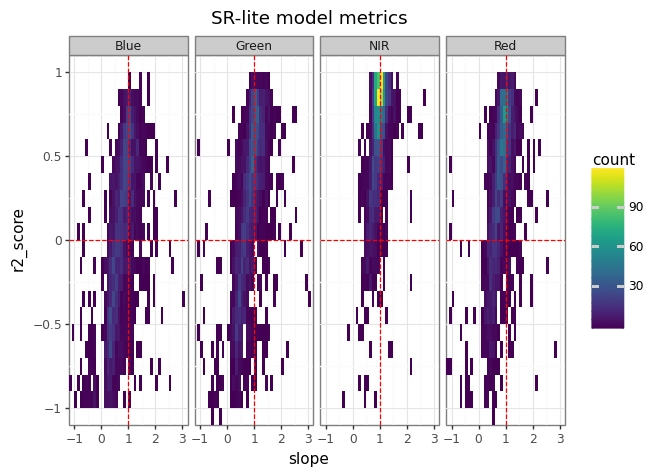

<ggplot: (1455524558809)>

In [21]:
(
    ggplot(srlite_metrics_df.dropna())
        + geom_bin2d(aes(x='slope', y='r2_score'), binwidth=0.1)
        + geom_hline(yintercept=0, linetype='dashed', color='red')
        + geom_vline(xintercept=1, linetype='dashed', color='red')
        + facet_wrap('~band_name', ncol=4)
        + theme_bw()
        + coord_cartesian(xlim=(-1,3), ylim=(-1,1))
        + labs(title='SR-lite model metrics')
)